# Generating Faces

**The goal is to create new faces of anime characters using a Deep Convolutional Generative Adversarial Network (DCGAN).**

## Importing libraries and loading data

In [3]:
import numpy as np
import os 
import matplotlib.pyplot as plt
import cv2

import warnings
warnings.filterwarnings('ignore')

import keras
from keras.optimizers import Adam
from keras.models import Sequential, Model
from keras.layers import Dense, LeakyReLU, Reshape, Flatten, Input
from keras.layers import Conv2D, MaxPooling2D, Activation, Dropout, Conv2DTranspose

from tensorflow.compat.v1.keras.layers import BatchNormalization

In [4]:
def list_images(basePath, contains=None):
    # return the set of files that are valid
    return list_files(basePath, validExts=(".jpg", ".jpeg", ".png", ".bmp"), contains=contains)

def list_files(basePath, validExts=(".jpg", ".jpeg", ".png", ".bmp"), contains=None):
    # loop over the directory structure
    for (rootDir, dirNames, filenames) in os.walk(basePath):
        # loop over the filenames in the current directory
        for filename in filenames:
            # if the contains string is not none and the filename does not contain
            # the supplied string, then ignore the file
            if contains is not None and filename.find(contains) == -1:
                continue

            # determine the file extension of the current file
            ext = filename[filename.rfind("."):].lower()

            # check to see if the file is an image and should be processed
            if ext.endswith(validExts):
                # construct the path to the image and yield it
                imagePath = os.path.join(rootDir, filename).replace(" ", "\\ ")
                yield imagePath
                
def load_images(directory='', size=(64,64)):
    images = []
    labels = []  # Integers corresponding to the categories in alphabetical order
    label = 0
    
    imagePaths = list(list_images(directory))
    
    for path in imagePaths:
        
        if not('OSX' in path):
        
            path = path.replace('\\','/')

            image = cv2.imread(path) #Reading the image with OpenCV
            image = cv2.resize(image,size) #Resizing the image, in case some are not of the same size

            images.append(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
    
    return images

In [5]:
images=load_images('../input/data')

## Looking at some images

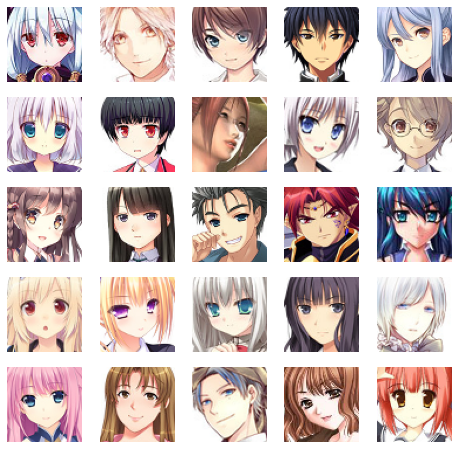

In [6]:
_,ax = plt.subplots(5,5, figsize = (8,8)) 
for i in range(5):
    for j in range(5):
        ax[i,j].imshow(images[5*i+j])
        ax[i,j].axis('off')

## Generative Adversarial Networks

The objective of a GAN is to train a data generator in order to imitate a given dataset.
A GAN is similar to a zero sum game between two neural networks, the generator of data and a discriminator, trained to recognize original data from fakes created by the generator.

<img src="https://skymind.ai/images/wiki/GANs.png" width="800px">

At each step, the discriminator is trained on a batch containing real and fake images. The generator is then trained to produce a batch of images.
<br>**In order to create effective GANs on images, we must use convolutional layers in the discriminator and in the generator.**

In a Deep Convolutional GAN, the data generator has the following structure :

<img src="https://pytorch.org/tutorials/_images/dcgan_generator.png" width="800px">

It takes a noise vector as the input in order to diversify the potential outputs.
<br><br>In a simplified way, after the training each dimension will correspond to a feature of the image, for example the hair shape of the character.

## Creating the GAN

In [7]:
class GAN():
    def __init__(self):
        self.img_shape = (64, 64, 3)
        
        self.noise_size = 100

        optimizer = Adam(0.0002,0.5)

        self.discriminator = self.build_discriminator()
        self.discriminator.compile(loss='binary_crossentropy', 
                                   optimizer=optimizer,
                                   metrics=['accuracy'])

        self.generator = self.build_generator()
        self.generator.compile(loss='binary_crossentropy', optimizer=optimizer)
        
        self.combined = Sequential()
        self.combined.add(self.generator)
        self.combined.add(self.discriminator)
        
        self.discriminator.trainable = False
        
        self.combined.compile(loss='binary_crossentropy', optimizer=optimizer)
        
        self.combined.summary()
        
    # Creating the generator, the large kernels in the convolutional layers allow the network to create complex structures.
    def build_generator(self):
        epsilon = 0.00001 # Small float added to variance to avoid dividing by zero in the BatchNorm layers.
        noise_shape = (self.noise_size,)
        
        model = Sequential()
        
        model.add(Dense(4*4*512, activation='linear', input_shape=noise_shape))
        model.add(LeakyReLU(alpha=0.2))
        model.add(Reshape((4, 4, 512)))
        
        model.add(Conv2DTranspose(512, kernel_size=[4,4], strides=[2,2], padding="same",
                                  kernel_initializer= keras.initializers.TruncatedNormal(stddev=0.02)))
        model.add(BatchNormalization(momentum=0.9, epsilon=epsilon))
        model.add(LeakyReLU(alpha=0.2))
        
        model.add(Conv2DTranspose(256, kernel_size=[4,4], strides=[2,2], padding="same",
                                  kernel_initializer= keras.initializers.TruncatedNormal(stddev=0.02)))
        model.add(BatchNormalization(momentum=0.9, epsilon=epsilon))
        model.add(LeakyReLU(alpha=0.2))
        
        model.add(Conv2DTranspose(128, kernel_size=[4,4], strides=[2,2], padding="same",
                                  kernel_initializer= keras.initializers.TruncatedNormal(stddev=0.02)))
        model.add(BatchNormalization(momentum=0.9, epsilon=epsilon))
        model.add(LeakyReLU(alpha=0.2))
        
        model.add(Conv2DTranspose(64, kernel_size=[4,4], strides=[2,2], padding="same",
                                  kernel_initializer= keras.initializers.TruncatedNormal(stddev=0.02)))
        model.add(BatchNormalization(momentum=0.9, epsilon=epsilon))
        model.add(LeakyReLU(alpha=0.2))
        
        model.add(Conv2DTranspose(3, kernel_size=[4,4], strides=[1,1], padding="same",
                                  kernel_initializer= keras.initializers.TruncatedNormal(stddev=0.02)))

        # Standard activation for the generator of a GAN
        model.add(Activation("tanh"))
        
        model.summary()

        noise = Input(shape=noise_shape)
        img = model(noise)

        return Model(noise, img)

    def build_discriminator(self):

        model = Sequential()

        model.add(Conv2D(128, (3,3), padding='same', input_shape=self.img_shape))
        model.add(LeakyReLU(alpha=0.2))
        model.add(BatchNormalization())
        model.add(Conv2D(128, (3,3), padding='same'))
        model.add(LeakyReLU(alpha=0.2))
        model.add(BatchNormalization())
        model.add(MaxPooling2D(pool_size=(3,3)))
        model.add(Dropout(0.2))

        model.add(Conv2D(128, (3,3), padding='same'))
        model.add(LeakyReLU(alpha=0.2))
        model.add(BatchNormalization())
        model.add(Conv2D(128, (3,3), padding='same'))
        model.add(LeakyReLU(alpha=0.2))
        model.add(BatchNormalization())
        model.add(MaxPooling2D(pool_size=(3,3)))
        model.add(Dropout(0.3))

        model.add(Flatten())
        model.add(Dense(128))
        model.add(LeakyReLU(alpha=0.2))
        model.add(Dense(128))
        model.add(LeakyReLU(alpha=0.2))
        model.add(Dense(1, activation='sigmoid'))
        
        model.summary()
        
        img = Input(shape=self.img_shape)
        validity = model(img)

        return Model(img, validity)

    def train(self, epochs, batch_size=128, metrics_update=50, save_images=100, save_model=2000):

        X_train = np.array(images)
        X_train = (X_train.astype(np.float32) - 127.5) / 127.5

        half_batch = int(batch_size / 2)
        
        mean_d_loss=[0,0]
        mean_g_loss=0

        for epoch in range(epochs):
            idx = np.random.randint(0, X_train.shape[0], half_batch)
            imgs = X_train[idx]

            noise = np.random.normal(0, 1, (half_batch, self.noise_size))
            gen_imgs = self.generator.predict(noise)

            # Training the discriminator
            
            # The loss of the discriminator is the mean of the losses while training on authentic and fake images
            d_loss = 0.5 * np.add(self.discriminator.train_on_batch(imgs, np.ones((half_batch, 1))),
                                  self.discriminator.train_on_batch(gen_imgs, np.zeros((half_batch, 1))))

            # Training the generator
            noise = np.random.normal(0, 1, (batch_size, self.noise_size))

            valid_y = np.array([1] * batch_size)
            g_loss = self.combined.train_on_batch(noise, valid_y)
            
            mean_d_loss[0] += d_loss[0]
            mean_d_loss[1] += d_loss[1]
            mean_g_loss += g_loss
            
            # We print the losses and accuracy of the networks every 200 batches mainly to make sure the accuracy of the discriminator
            # is not stable at around 50% or 100% (which would mean the discriminator performs not well enough or too well)
            if epoch % metrics_update == 0:
                print ("%d [Discriminator loss: %f, acc.: %.2f%%] [Generator loss: %f]" % (epoch, mean_d_loss[0]/metrics_update, 100*mean_d_loss[1]/metrics_update, mean_g_loss/metrics_update))
                mean_d_loss=[0,0]
                mean_g_loss=0
            
            # Saving 25 images
            if epoch % save_images == 0:
                self.save_images(epoch)
            
            # We save the architecture of the model, the weights and the state of the optimizer
            # This way we can restart the training exactly where we stopped
            if epoch % save_model == 0:
                self.generator.save("generator_%d" % epoch)
                self.discriminator.save("discriminator_%d" % epoch)

    # Saving 25 generated images to have a representation of the spectrum of images created by the generator
    def save_images(self, epoch):
        noise = np.random.normal(0, 1, (25, self.noise_size))
        gen_imgs = self.generator.predict(noise)
        
        # Rescale from [-1,1] into [0,1]
        gen_imgs = 0.5 * gen_imgs + 0.5

        fig, axs = plt.subplots(5,5, figsize = (8,8))

        for i in range(5):
            for j in range(5):
                axs[i,j].imshow(gen_imgs[5*i+j])
                axs[i,j].axis('off')

        plt.show()
        
        fig.savefig("animeGenerated/Faces_%d.png" % epoch)
        plt.close()

## Training the networks

In [8]:
#This folder will contain the images generated during the training
!mkdir animeGenerated

### Things to keep in mind while training a GAN

**In the case of a GAN, cost functions may not converge using gradient descent.**
<br/>Training a GAN is very different from training a regular neural network. The main difference come from the fact that the discriminator also evolves.
Therefore, the cost function that the generator tries to minimize is also evolving.

**The discriminator must be powerful enough to recognize small differences between the real and fake images.**
<br/>If the discriminator does not perform well, the generator cannot progress.
If the accuracy of the discriminator stabilizes near 50%, the generator already tricks the discriminator well and does not need to improve.

**The two networks must progress in synergy to avoid a diminished gradient during the training of the generator.**
<br/>The discriminator must not be too effective at the beginning, if it is, the generator will not progress until it randomly creates a very convincing image.

We want to avoid **mode collapse** which is when the generator creates the same output no matter the input noise.
It leads to an overfitting from the discriminator which remembers the features of the fake, no matter how convincing it is.

**A high learning rate creates a situation in which both networks overfit to exploit short term opponent weaknesses.**
<br/>The **learning rate** of the optimizer must be carefully chosen.
A high learning rate prevents the generator from reaching a certain level of details, it prevents the convergence.
It also leads to an overfitting from the discriminator which recognizes the most recent features made by the generator but forgets the previous ones.

### Training session

A high batch size leads to a more regular convergence.

We will save the model at the end of the training, we save the architecture of the model, the weights and the state of the optimizer. It allows us to restart the training exactly where we stopped.

We will look at a sample of images every 1000 epoch.

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 64, 64, 128)       3584      
_________________________________________________________________
leaky_re_lu (LeakyReLU)      (None, 64, 64, 128)       0         
_________________________________________________________________
batch_normalization (BatchNo (None, 64, 64, 128)       512       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 64, 64, 128)       147584    
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 64, 64, 128)       0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 64, 64, 128)       512       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 21, 21, 128)       0

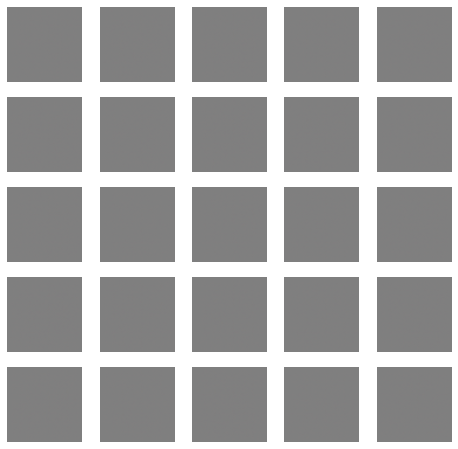

200 [Discriminator loss: 0.305253, acc.: 89.20%] [Generator loss: 2.752882]
400 [Discriminator loss: 0.368387, acc.: 84.52%] [Generator loss: 2.853973]
600 [Discriminator loss: 0.365113, acc.: 84.97%] [Generator loss: 3.135652]
800 [Discriminator loss: 0.328045, acc.: 86.19%] [Generator loss: 3.533303]
1000 [Discriminator loss: 0.322608, acc.: 86.77%] [Generator loss: 3.787172]


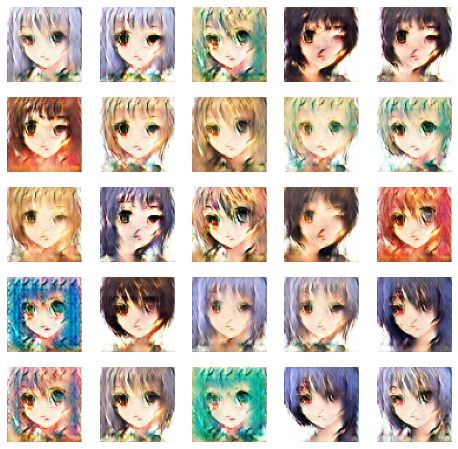

1200 [Discriminator loss: 0.276153, acc.: 88.54%] [Generator loss: 4.057499]
1400 [Discriminator loss: 0.240156, acc.: 90.78%] [Generator loss: 3.729271]
1600 [Discriminator loss: 0.256039, acc.: 89.64%] [Generator loss: 3.974937]
1800 [Discriminator loss: 0.269908, acc.: 88.81%] [Generator loss: 4.204811]
2000 [Discriminator loss: 0.331633, acc.: 85.87%] [Generator loss: 3.811656]


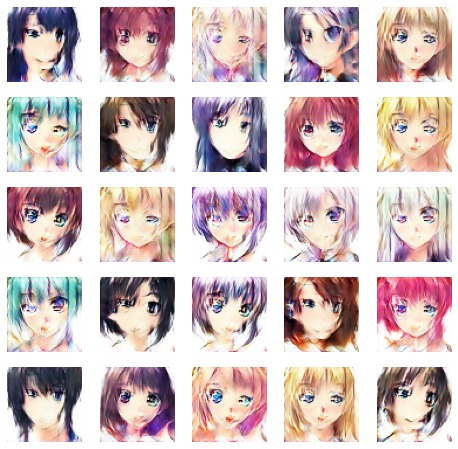

2200 [Discriminator loss: 0.339150, acc.: 85.08%] [Generator loss: 3.846052]
2400 [Discriminator loss: 0.326475, acc.: 85.95%] [Generator loss: 3.892223]
2600 [Discriminator loss: 0.317189, acc.: 86.43%] [Generator loss: 4.003309]
2800 [Discriminator loss: 0.299861, acc.: 87.13%] [Generator loss: 4.000551]
3000 [Discriminator loss: 0.307171, acc.: 86.76%] [Generator loss: 3.999058]


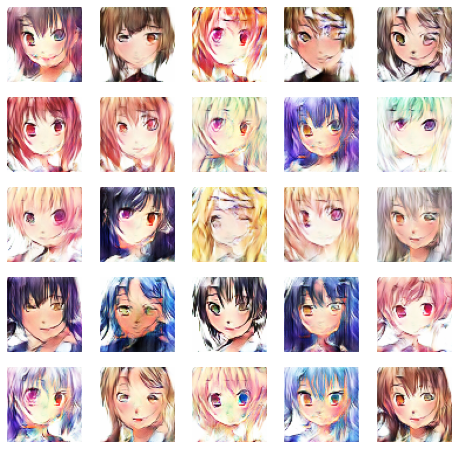

3200 [Discriminator loss: 0.289063, acc.: 87.76%] [Generator loss: 4.044233]
3400 [Discriminator loss: 0.306057, acc.: 86.97%] [Generator loss: 3.856423]
3600 [Discriminator loss: 0.307877, acc.: 86.92%] [Generator loss: 4.004815]
3800 [Discriminator loss: 0.305199, acc.: 86.96%] [Generator loss: 3.884679]
4000 [Discriminator loss: 0.295682, acc.: 87.45%] [Generator loss: 4.075720]


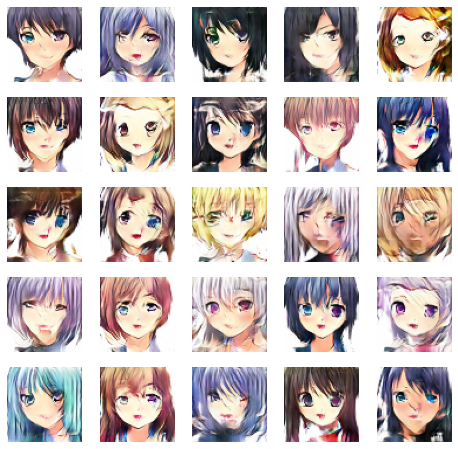

4200 [Discriminator loss: 0.292674, acc.: 87.69%] [Generator loss: 4.068668]
4400 [Discriminator loss: 0.291405, acc.: 87.53%] [Generator loss: 4.028322]
4600 [Discriminator loss: 0.269404, acc.: 88.71%] [Generator loss: 4.128309]
4800 [Discriminator loss: 0.258682, acc.: 89.26%] [Generator loss: 4.323237]
5000 [Discriminator loss: 0.280355, acc.: 88.47%] [Generator loss: 4.329190]


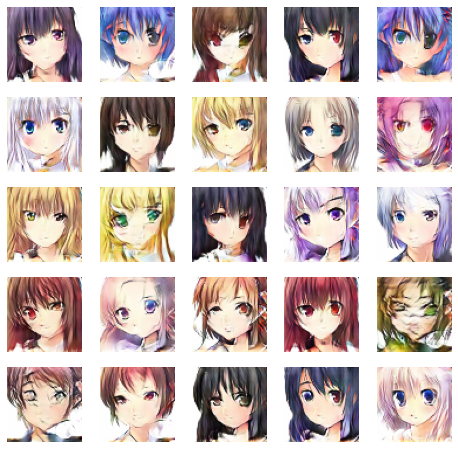

5200 [Discriminator loss: 0.256429, acc.: 89.31%] [Generator loss: 4.289039]
5400 [Discriminator loss: 0.255239, acc.: 89.49%] [Generator loss: 4.404315]
5600 [Discriminator loss: 0.266830, acc.: 88.90%] [Generator loss: 4.343918]
5800 [Discriminator loss: 0.258200, acc.: 89.39%] [Generator loss: 4.344653]
6000 [Discriminator loss: 0.248440, acc.: 89.70%] [Generator loss: 4.426254]


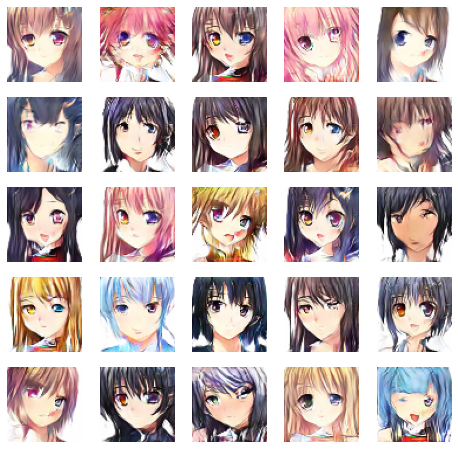

6200 [Discriminator loss: 0.257174, acc.: 89.30%] [Generator loss: 4.438875]
6400 [Discriminator loss: 0.250239, acc.: 89.56%] [Generator loss: 4.486832]
6600 [Discriminator loss: 0.250840, acc.: 89.60%] [Generator loss: 4.529731]
6800 [Discriminator loss: 0.254133, acc.: 89.48%] [Generator loss: 4.639705]
7000 [Discriminator loss: 0.249667, acc.: 89.66%] [Generator loss: 4.519223]


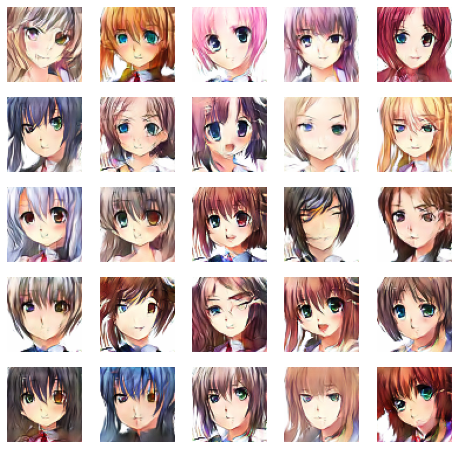

7200 [Discriminator loss: 0.240556, acc.: 90.07%] [Generator loss: 4.619263]
7400 [Discriminator loss: 0.222083, acc.: 90.91%] [Generator loss: 4.934868]
7600 [Discriminator loss: 0.231022, acc.: 90.60%] [Generator loss: 4.754293]
7800 [Discriminator loss: 0.235049, acc.: 90.46%] [Generator loss: 4.756963]
8000 [Discriminator loss: 0.241849, acc.: 90.19%] [Generator loss: 4.669044]


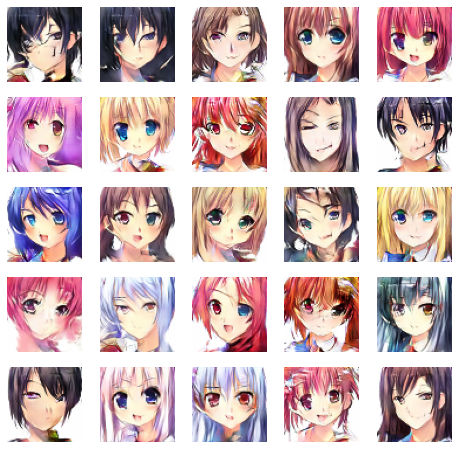

8200 [Discriminator loss: 0.219574, acc.: 90.99%] [Generator loss: 4.879822]
8400 [Discriminator loss: 0.230916, acc.: 90.62%] [Generator loss: 4.735640]
8600 [Discriminator loss: 0.228733, acc.: 90.69%] [Generator loss: 4.706175]
8800 [Discriminator loss: 0.214224, acc.: 91.35%] [Generator loss: 4.860143]
9000 [Discriminator loss: 0.209341, acc.: 91.53%] [Generator loss: 5.044726]


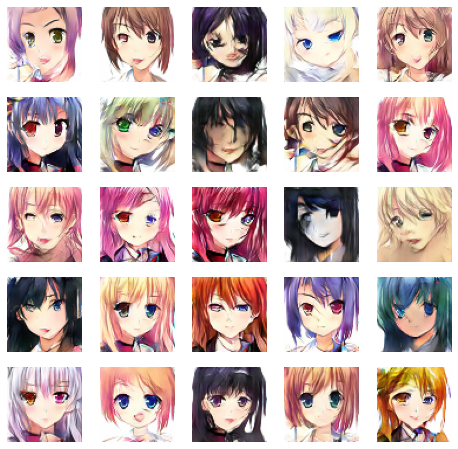

9200 [Discriminator loss: 0.221420, acc.: 91.02%] [Generator loss: 4.849843]
9400 [Discriminator loss: 0.211779, acc.: 91.44%] [Generator loss: 5.025082]
9600 [Discriminator loss: 0.236942, acc.: 90.46%] [Generator loss: 4.875343]
9800 [Discriminator loss: 0.215165, acc.: 91.45%] [Generator loss: 4.904642]
10000 [Discriminator loss: 0.195179, acc.: 92.12%] [Generator loss: 5.116079]


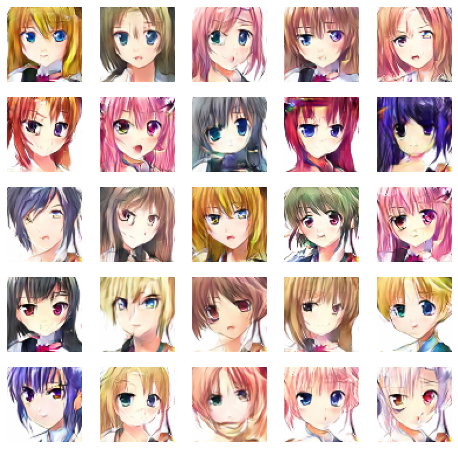

10200 [Discriminator loss: 0.193814, acc.: 92.20%] [Generator loss: 5.216970]
10400 [Discriminator loss: 0.209123, acc.: 91.94%] [Generator loss: 5.051050]
10600 [Discriminator loss: 0.197686, acc.: 92.05%] [Generator loss: 5.252793]
10800 [Discriminator loss: 0.198897, acc.: 92.25%] [Generator loss: 5.103275]
11000 [Discriminator loss: 0.179039, acc.: 92.97%] [Generator loss: 5.240368]


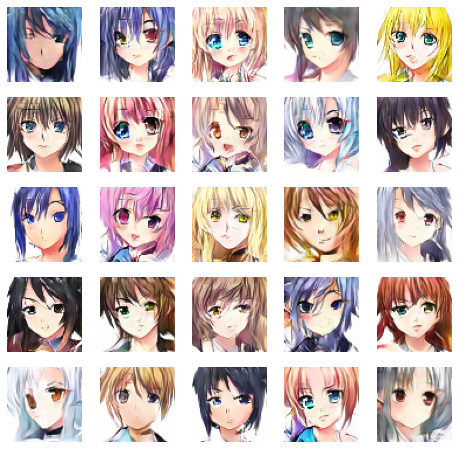

11200 [Discriminator loss: 0.182132, acc.: 92.93%] [Generator loss: 5.415231]
11400 [Discriminator loss: 0.194298, acc.: 92.61%] [Generator loss: 5.227710]
11600 [Discriminator loss: 0.190734, acc.: 92.61%] [Generator loss: 5.247124]
11800 [Discriminator loss: 0.173746, acc.: 93.16%] [Generator loss: 5.379123]
12000 [Discriminator loss: 0.190113, acc.: 92.75%] [Generator loss: 5.376771]


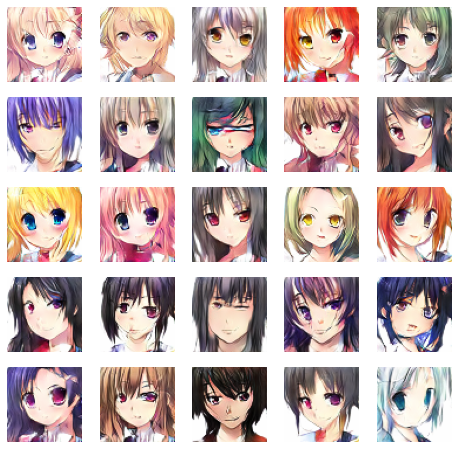

12200 [Discriminator loss: 0.170922, acc.: 93.23%] [Generator loss: 5.415644]
12400 [Discriminator loss: 0.184473, acc.: 92.95%] [Generator loss: 5.361489]
12600 [Discriminator loss: 0.161772, acc.: 93.70%] [Generator loss: 5.553456]
12800 [Discriminator loss: 0.194256, acc.: 92.62%] [Generator loss: 5.232662]
13000 [Discriminator loss: 0.179331, acc.: 93.13%] [Generator loss: 5.386573]


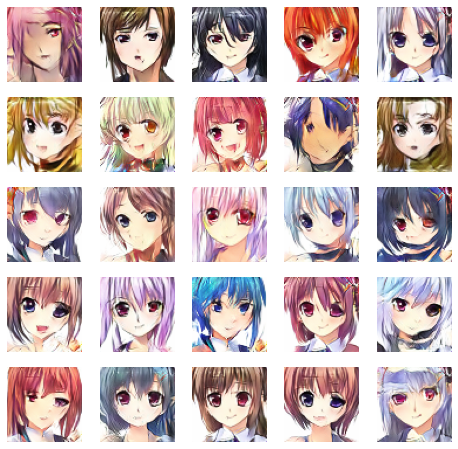

13200 [Discriminator loss: 0.186770, acc.: 93.03%] [Generator loss: 5.312298]
13400 [Discriminator loss: 0.149738, acc.: 94.08%] [Generator loss: 5.599060]
13600 [Discriminator loss: 0.156603, acc.: 93.86%] [Generator loss: 5.793105]
13800 [Discriminator loss: 0.229413, acc.: 91.50%] [Generator loss: 5.025506]
14000 [Discriminator loss: 0.198053, acc.: 92.54%] [Generator loss: 5.190660]


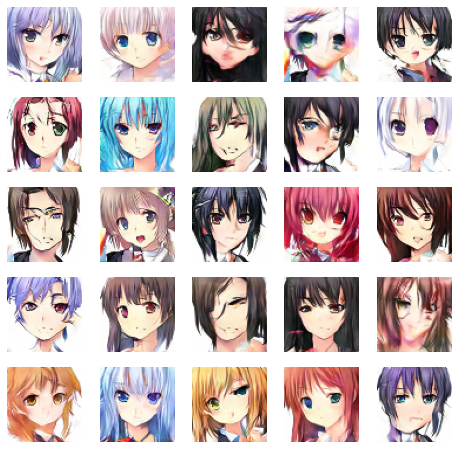

14200 [Discriminator loss: 0.159289, acc.: 93.80%] [Generator loss: 5.545531]
14400 [Discriminator loss: 0.167175, acc.: 93.51%] [Generator loss: 5.531605]
14600 [Discriminator loss: 0.194909, acc.: 92.45%] [Generator loss: 5.239525]
14800 [Discriminator loss: 0.150689, acc.: 94.21%] [Generator loss: 5.441639]
15000 [Discriminator loss: 0.152255, acc.: 93.99%] [Generator loss: 5.730590]


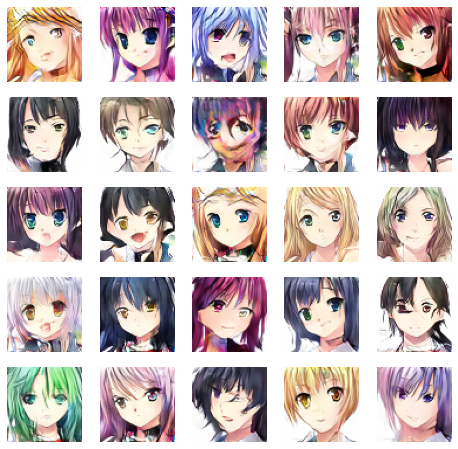

In [9]:
gan=GAN()
gan.train(epochs=15001, batch_size=256, metrics_update=200, save_images=1000, save_model=15000)

A few images are convincing and those images present different hair styles, hair colors or face orientations.

**We avoided mode collapse** and the networks seem to have a good synergy with a stable accuracy at around 85% for the discriminator during most of the training.

Howerver, the generator does not create globally convincing faces, for example some of them present different shape and colors between the two eyes.

In [10]:
!pip show tensorflow

In [11]:
!pip show keras

Name: Keras
Version: 2.4.3
Summary: Deep Learning for humans
Home-page: https://github.com/keras-team/keras
Author: Francois Chollet
Author-email: francois.chollet@gmail.com
License: MIT
Location: /opt/conda/lib/python3.7/site-packages
Requires: h5py, numpy, scipy, pyyaml
Required-by: fancyimpute
